In [34]:
import numpy as np
import pandas as pd
import os
import pickle

# Other packages
import analyzer.loaders.cremona.utils as u
import analyzer.loaders.cremona as cremona
import analyzer.loaders.hmfundacion.hmfundacion as hmfundacion
from analyzer.utils import store_json, change_SaO2
import analyzer.dataset as ds

import shap

# import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default='browser'

In [35]:
import matplotlib.pyplot as plt

## Load Model and Data

Select model type.  
- **model_type** = 'mortality' or 'infection'
- **model_lab** = 'with_lab' or 'without_lab'

In [36]:
model_type = 'infection'
model_lab = 'with_lab'

assert model_type in('mortality','infection'), "Invalid outcome"
assert model_lab in('with_lab','without_lab'), "Invalid lab specification"

Set paths for data/model loading

In [37]:
website_path = '/Users/hollywiberg/git/website/'
path_cremona = '/Users/hollywiberg/Dropbox (MIT)/COVID_risk/covid19_cremona/data/'
path_hm = '/Users/hollywiberg/Dropbox (MIT)/COVID_risk/covid19_hmfoundation/'

Load model corresponding to *model_type* and *model_lab*.

In [38]:
with open(website_path+'assets/risk_calculators/'+model_type+'/model_'+model_lab+'.pkl', 'rb') as file:
    model_file = pickle.load(file)
    
model = model_file['model']
features = model_file['json']
columns = model_file['columns']
imputer= model_file['imputer']

Trying to unpickle estimator BayesianRidge from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator IterativeImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.


In [39]:
SEED = 1

## Variables determined by input
prediction = 'Outcome'if model_type == 'mortality' else 'Swab'
swabs_data = False if model_type == 'mortality' else True
comorbidities_data = True if model_type == 'mortality' else False
discharge_data = True if model_type == 'mortality' else False 
lab_tests = True if model_lab == 'with_lab' else False

# ## Constant variables
extra_data = False
demographics_data = True
vitals_data = True

name_datasets = np.asarray(['discharge', 'comorbidities', 'vitals', 'lab', 'demographics', 'swab'])
mask = np.asarray([discharge_data, comorbidities_data, vitals_data, lab_tests, demographics_data, swabs_data])
print(name_datasets[mask])

## Load Cremona data
data = cremona.load_cremona(path_cremona, discharge_data, comorbidities_data, vitals_data, lab_tests, demographics_data, swabs_data)
X_cremona, y_cremona = ds.create_dataset(data, discharge_data, comorbidities_data, vitals_data,
                                      lab_tests, demographics_data, swabs_data, prediction = prediction)

if model_type == "mortality":
    ## Load Spain data
    data_spain = hmfundacion.load_fundacionhm(path_hm, discharge_data, comorbidities_data, vitals_data, lab_tests, demographics_data, extra_data)
    X_spain, y_spain =  ds.create_dataset(data_spain, discharge_data, comorbidities_data, vitals_data,
                                          lab_tests, demographics_data, swabs_data, prediction = prediction)

    # Merge datasets, filter outliers, match format of stored model
    X0 = pd.concat([X_cremona, X_spain], join='inner', ignore_index=True)
    y = pd.concat([y_cremona, y_spain], ignore_index=True)
else: 
    X0, y = X_cremona, y_cremona

X0, bounds_dict = ds.filter_outliers(X0)
X0 = X0[columns] 

X = pd.DataFrame(imputer.transform(X0))
X.columns =  X0.columns


['vitals' 'lab' 'demographics' 'swab']


Columns (58) have mixed types.Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ABG: Base Excess: LB = -21.0, UB = 13.0 (Filter = 4)
ABG: COHb: LB = 0.0, UB = 7.0 (Filter = 2)
ABG: Lactic Acid: LB = 0.0, UB = 12.0 (Filter = 2)
ABG: MetHb: LB = 0.0, UB = 2.0 (Filter = 2)
ABG: Oxygen Saturation (SaO2): LB = 28.0, UB = 100.0 (Filter = 2)
ABG: PaCO2: LB = 15.0, UB = 72.0 (Filter = 4)
ABG: PaO2: LB = 18.0, UB = 311.0 (Filter = 5)
ABG: pH: LB = 7.0, UB = 8.0 (Filter = 1)
ABG: standard bicarbonate (sHCO3): LB = 9.0, UB = 37.0 (Filter = 3)
Activated Partial Thromboplastin Time (aPTT): LB = 0.0, UB = 6.0 (Filter = 0)
Age: LB = 0.0, UB = 99.0 (Filter = 3)
Alanine Aminotransferase (ALT): LB = 1.0, UB = 651.0 (Filter = 4)
Aspartate Aminotransferase (AST): LB = 9.0, UB = 878.0 (Filter = 4)
Blood Amylase: LB = 12.0, UB = 814.0 (Filter = 5)
Blood Calcium: LB = 5.0, UB = 12.0 (Filter = 2)
Blood Creatinine: LB = 0.0, UB = 12.0 (Filter = 3)
Blood Sodium: LB = 114.0, UB = 161.0 (Filter = 5)
Blood Urea Nitrogen (BUN): LB = 4.0, UB = 221.0 (Filter = 3)
Body Temperature: LB = 95.0, UB 

In [40]:
from sklearn.metrics import roc_curve, auc, accuracy_score

pred_Y = model.predict_proba(X)[:, 1]

is_fpr, is_tpr, thresh = roc_curve(y, pred_Y)

accuracy_scores = []
for t in thresh:
    accuracy_scores.append(accuracy_score(y, 
                                         [1 if m > t else 0 for m in pred_Y]))

In [41]:
auc(is_fpr, is_tpr)

0.8999119393999299

In [42]:
X

,Age,Gender,Systolic Blood Pressure,Respiratory Frequency,Body Temperature,ABG: Oxygen Saturation (SaO2),C-Reactive Protein (CRP),CBC: Leukocytes,Blood Calcium,CBC: Platelets,Blood Creatinine,CBC: Mean Corpuscular Volume (MCV),Prothrombin Time (INR),Blood Sodium,CBC: Red cell Distribution Width (RDW),Aspartate Aminotransferase (AST),Blood Urea Nitrogen (BUN),Alanine Aminotransferase (ALT),Total Bilirubin,CBC: Hemoglobin
0,59.0,1.0,125.000000,18.000000,96.980003,88.800003,21.290001,8.088640,9.472377,279.008331,0.68,87.560402,1.00,146.0,14.032048,39.0,11.0,42.0,0.64,13.059275
1,82.0,0.0,115.000000,18.000000,100.010002,85.057678,292.089996,6.030000,9.200000,182.000000,0.79,91.800003,0.95,145.0,14.000000,43.0,19.0,29.0,0.71,14.900000
2,84.0,0.0,132.500000,22.000000,100.639999,88.099998,266.130005,9.081553,9.200000,120.000000,1.16,88.300003,1.10,140.0,13.800000,73.0,26.0,26.0,0.85,14.500000
3,83.0,0.0,90.000000,18.000000,97.160004,91.634438,50.790001,5.840000,8.900000,101.000000,2.23,96.099998,1.02,136.0,13.500000,19.0,36.0,12.0,0.65,10.900000
4,86.0,0.0,100.000000,18.107706,99.339996,94.500000,60.099998,6.956704,8.500000,171.082153,1.56,88.323868,1.10,140.0,14.127547,14.0,24.0,7.0,0.63,12.937367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,86.0,1.0,155.000000,18.000000,102.019997,95.400002,5.180000,14.780000,9.400000,297.000000,0.88,95.900002,1.07,139.0,15.700000,28.0,17.0,16.0,0.96,13.600000
3131,65.0,0.0,146.399994,17.261526,97.160004,92.889206,0.540000,4.510000,9.200000,185.000000,0.92,92.400002,1.09,150.0,12.500000,29.0,20.0,14.0,0.94,13.400000
3132,73.0,0.0,190.000000,18.000000,96.800003,94.821854,26.930000,9.030000,9.400000,179.000000,0.85,89.500000,1.08,143.0,12.900000,19.0,16.0,14.0,0.79,16.100000
3133,66.0,0.0,140.000000,16.000000,96.800003,96.087662,2.130000,6.230000,9.700000,186.000000,0.91,84.900002,0.99,141.0,13.400000,21.0,11.0,16.0,1.36,15.200000


## Evaluate Model with SHAP

In [43]:
shap.initjs()

##### Calculate SHAP values (for each observation x feature)

In [44]:
shap.initjs()

explainer = shap.TreeExplainer(model);
shap_values = explainer.shap_values(X);

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


##### Summarize SHAP values across all features
This acts as an alterative to the standard variable importance plots. Higher SHAP values translate to higher probability of mortality.

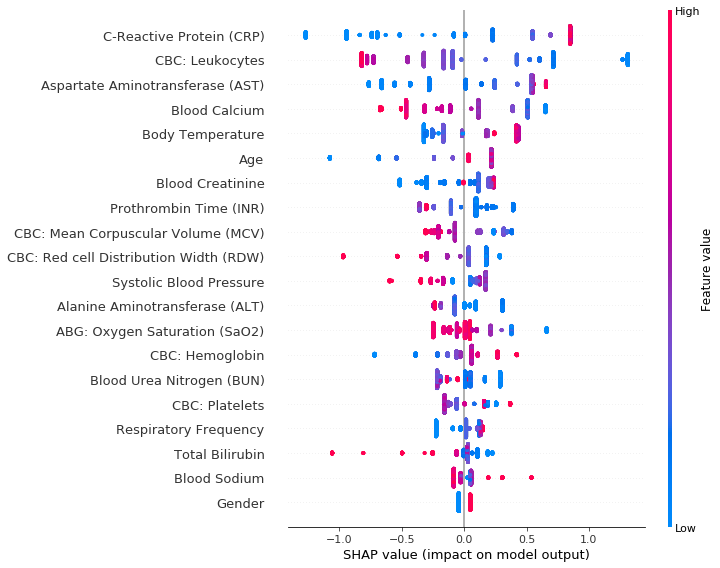

In [45]:
# shap.summary_plot(shap_values, X).
shap.summary_plot(shap_values, X,show=False)
f = plt.gcf()
f.savefig('../results/'+model_type+'/model_'+model_lab+'/summary_plot.png', bbox_inches='tight')

##### Deep-dive into individual features
For a given feature, see how the SHAP varies across its possible values. The interaction_index lets you choose a secondary index to visualize. If omitted, it will automatically find the variable with the highest interaction.

invalid value encountered in true_divide
invalid value encountered in true_divide


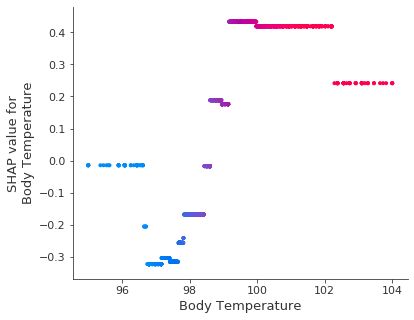

In [50]:
shap.dependence_plot("Body Temperature", shap_values, X)

In [ ]:
# shap.dependence_plot("Systolic Blood Pressure", shap_values, X, interaction_index = "Age")
for i in X.columns:
    shap.dependence_plot(i, shap_values, X,show=False)
    f = plt.gcf()
    f.savefig('../results/'+model_type+'/model_'+model_lab+'/dependence_plot_'+i+'.png', bbox_inches='tight')

##### Evaluate drivers of individual predictions 
Select index j for prediction to generate.

In [52]:
# shap.force_plot(explainer.expected_value, shap_values[1:10,:], X.iloc[[1:10,:]])
j=1
plot = shap.force_plot(explainer.expected_value, shap_values[j], X.iloc[[j]] , link="logit")
plot

As an alternative view, you can trace a 3D plot of the values and their impact on the prediction.